**Identifying features that influence low-income student success**

by Ben Lacar
<br>
March 2019

Next:
- try both random forest and linear/ridge regression
- apply k-fold cross-validation


In [174]:
# Import packages

import os

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

# Unsupervised learning
from sklearn.decomposition import PCA

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import shap

# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest

<IPython.core.display.Javascript object>

In [2]:
# Colors and formatting
# Got Google theme html colors from here https://imagecolorpicker.com
B_beige = "#CDA577"
B_brown = "#643E34"
B_slate = "#3F5B66"
B_dkgray = "#5A7E8E"
B_ltgray = "#6D949B"
B_green = "#01CB8B"
B_lime = "#D3F04A"

B_colors = [B_beige, B_brown, B_slate, B_dkgray, B_ltgray, B_green, B_lime]
B_colors_cat = [B_beige, B_green, B_brown, B_ltgray, B_slate, B_lime, B_dkgray]

# Code formatting Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

# Import data

In [3]:
parent_path = "/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/"
os.chdir(parent_path)
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

<IPython.core.display.Javascript object>

In [30]:
# Import data from data cleaning
df_state_info_gs_census = pd.read_csv(
    "data/b_intermediate/df_state_info_gs_census_200514.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [41]:
df_state_info_gs_census.shape

(966, 70)

<IPython.core.display.Javascript object>

In [288]:
df_state_info_gs_census.columns

Index(['NCESDist', 'NCESSchool', 'NCESDistSchool', 'StatusType', 'County',
       'District', 'School', 'Street', 'StreetAbr', 'City', 'Zip', 'zip_code',
       'State', 'Latitude', 'Longitude', 'E12',
       '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
       '%; INCOME_BENEFITS - w/ Social Security',
       '%; INCOME_BENEFITS - w/ Supplemental Security Income',
       'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
       '%; WORK_C

<IPython.core.display.Javascript object>

## Evaluate missing data

Text(0, 0.5, 'No. of features')

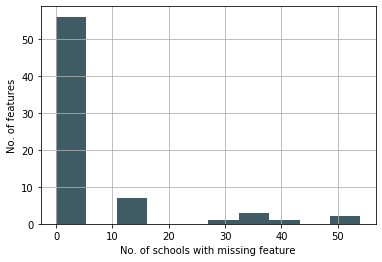

<IPython.core.display.Javascript object>

In [42]:
f, ax1 = plt.subplots()
df_state_info_gs_census.isna().sum().hist(ax=ax1, color=B_slate)
ax1.set_xlabel('No. of schools with missing feature')
ax1.set_ylabel('No. of features')

In [43]:
df_state_info_gs_census.isna().sum().sort_values(ascending=False).head(20)

test_scores_math_LIstudents                                                                          54
test_scores_math_LIstudents_n_students                                                               52
students_per_counselor                                                                               43
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)    33
Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)                            33
Est.; INCOME_BENEFITS - Total households - Median household income ($)                               33
test_score_rating_notLIstudents                                                                      30
graduation_rates_UCCSU_eligibility_LIstudents                                                        13
graduation_rates_UCCSU_eligibility_allStudents                                                       13
graduation_rates_UCCSU_eligibility_nonLIstudents                

<IPython.core.display.Javascript object>

**What counties and districts are missing values of test scores? (SQL query)**

In [44]:
df_state_info_gs_census.loc[df_state_info_gs_census['test_scores_math_LIstudents'].isna(), :].groupby('County').count().iloc[:, 0]

County
Alameda         4
Colusa          1
Fresno          2
Inyo            1
Kern            1
Los Angeles    34
Mendocino       3
Riverside       2
Sacramento      2
San Diego       1
San Joaquin     1
Siskiyou        1
Yolo            1
Name: NCESDist, dtype: int64

<IPython.core.display.Javascript object>

In [45]:
df_state_info_gs_census.loc[df_state_info_gs_census['test_scores_math_LIstudents'].isna(), :].groupby('County').count().iloc[:, 0].sum()

54

<IPython.core.display.Javascript object>

In [46]:
df_state_info_gs_census.loc[df_state_info_gs_census['test_scores_math_LIstudents'].isna(), :].groupby('District').count().iloc[:, 0]

District
Acton-Agua Dulce Unified            1
Borrego Springs Unified             1
Coachella Valley Unified            2
Delano Joint Union High             1
Esparto Unified                     1
Inyo County Office of Education     1
Laton Joint Unified                 1
Laytonville Unified                 1
Lennox                              1
Los Angeles Unified                30
Mendota Unified                     1
Oakland Unified                     4
Point Arena Joint Union High        1
Pomona Unified                      2
Round Valley Unified                1
Sacramento City Unified             1
Siskiyou Union High                 1
Stockton Unified                    1
Twin Rivers Unified                 1
Williams Unified                    1
Name: NCESDist, dtype: int64

<IPython.core.display.Javascript object>

In [47]:
df_state_info_gs_census = df_state_info_gs_census.dropna().copy()

<IPython.core.display.Javascript object>

In [48]:
print('{0:d} schools have values for all {1:d} features'.format(df_state_info_gs_census.shape[0], df_state_info_gs_census.shape[1]))

814 schools have values for all 70 features


<IPython.core.display.Javascript object>

**Assign the 0/1 value for exceptional schools for SPLICE as the target.**

In [50]:
thresh = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].mean() + df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].std()
df_state_info_gs_census['splice_high'] = 0
bool_splice_high = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'] > thresh
df_state_info_gs_census.loc[bool_splice_high, 'splice_high'] = 1

<IPython.core.display.Javascript object>

# Split data into train-validation-test

Here are my definitions of these terms:
- train: set for recursive feature selection, using an initial set of model parameters
- validation: set for tuning of hyperparameters (e.g. tree depth)
- test: set that is held out completely until final model valuation (logistic regression vs. random forest)

I'll apply 60-20-20 split. This first split (80/20) is getting the test set separated. The other 80% of the data will be used in finding hyperparameters in a 4-fold cross-validation.

In [52]:
def get_split_data(X, y, testsize):

    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = pd.merge(X, y, left_index=True, right_index=True).notnull().sum(
        axis=1
    ) == (X.shape[1] + 1)
    print(
        "No. of total schools before splitting (no null values for feature set or target): ",
        sum(k_rows2keep),
    )

    X = X.loc[k_rows2keep, :].copy()
    y = y[k_rows2keep].copy()

    # Split data between train and test_(and_holdout?)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

**The dataset at this point contains columns that are not features that I want to include in the model (such as street address). The next cell creates a variable that includes the desired features.**

In [241]:
all_features_filt_wcensuscheck = df_state_info_gs_census.columns.tolist()[15::]

<IPython.core.display.Javascript object>

**Remove the target and eligibility for all students which is a superset of college eligibility for LI students.**

In [242]:
rm_feat = [
    "graduation_rates_UCCSU_eligibility_allStudents",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    "splice_high"
]

all_features_filt_wcensuscheck_notarget = [
    x for x in all_features_filt_wcensuscheck if x not in rm_feat
]
target = "splice_high"

<IPython.core.display.Javascript object>

In [243]:
X = df_state_info_gs_census[all_features_filt_wcensuscheck_notarget].copy()
y = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [244]:
X_train, X_test, y_train, y_test = get_split_data(X, y, 0.2)

No. of total schools before splitting (no null values for feature set or target):  814


<IPython.core.display.Javascript object>

# Logistic regression, target: exceptional schools

Similar to [this blog](https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5)

## Scale data

In [245]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_LR = scaler.transform(X_train)
X_test_LR = scaler.transform(X_test)

<IPython.core.display.Javascript object>

## Run 4-fold cross-validation to get optimal parameters

In [247]:
# Instantiate model
log_reg = LogisticRegression()

# Randomized search using 4-fold cross-validation
log_reg_random = RandomizedSearchCV(
    estimator=log_reg,  # the model
    param_distributions=random_grid,  # from above
    n_iter=5,  # no. of parameter settings sampled
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="f1",  
    return_train_score=True,  # computationally expensive, but output here for insight
)

log_reg_random_search = log_reg_random.fit(X_train_LR, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


<IPython.core.display.Javascript object>

In [248]:
print('List of hyperparameters for best fit: ', log_reg_random_search.best_params_)

List of hyperparameters for best fit:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.08858667904100823}


<IPython.core.display.Javascript object>

In [249]:
print('Full list of hyperparameters: ', log_reg_random_search.best_estimator_.get_params())

Full list of hyperparameters:  {'C': 0.08858667904100823, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


<IPython.core.display.Javascript object>

**Fit model using hyperparameters.**

In [313]:
log_reg_best = LogisticRegression(**log_reg_random_search.best_params_, class_weight='balanced')
log_reg_best.fit(X_train_LR, y_train)

LogisticRegression(C=0.08858667904100823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

## Evalute optimized parameters on test (hold out) set

In [314]:
y_pred_LR = log_reg_best.predict(X_test_LR)
df_eval_LR = pd.DataFrame({"test": y_test, "pred": y_pred_LR})

<IPython.core.display.Javascript object>

In [315]:
confusion_matrix(df_eval_LR['test'], df_eval_LR['pred'])

array([[132,  12],
       [  2,  17]])

<IPython.core.display.Javascript object>

In [316]:
print(classification_report(df_eval_LR['test'], df_eval_LR['pred']))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       144
           1       0.59      0.89      0.71        19

    accuracy                           0.91       163
   macro avg       0.79      0.91      0.83       163
weighted avg       0.94      0.91      0.92       163



<IPython.core.display.Javascript object>

Recall: 0.8947
Accuracy: 0.9141
Precision: 0.5862
[[132  12]
 [  2  17]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       144
           1       0.59      0.89      0.71        19

    accuracy                           0.91       163
   macro avg       0.79      0.91      0.83       163
weighted avg       0.94      0.91      0.92       163



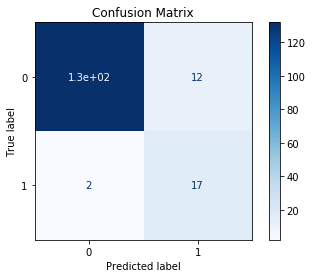

<IPython.core.display.Javascript object>

In [317]:
# Compute and print the confusion matrix and classification report
print('Recall: %.4f' %metrics.recall_score(df_eval_LR['test'], df_eval_LR['pred']))
print('Accuracy: %.4f' %log_reg_best.score(X_test_LR, y_test))
print('Precision: %.4f' %metrics.precision_score(df_eval_LR['test'], df_eval_LR['pred']))
print(confusion_matrix(df_eval_LR['test'], df_eval_LR['pred']))
print(classification_report(df_eval_LR['test'], df_eval_LR['pred']))

f, ax1 = plt.subplots()
plot_confusion_matrix(log_reg_best, X_test_LR, y_test, labels=None, 
                             sample_weight=None, normalize=None, display_labels=None, 
                             include_values=True, xticks_rotation='horizontal', 
                             values_format='d', cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix');

## Most important features by logistic regression coefficients

                                                 name     coeff
15  %; INDUSTRY - Civilian employed pop. 16 yrs an... -0.283488
34                                         enrollment -0.279608
6   Est.; INCOME_BENEFITS - w/ cash public assista... -0.257663
7   %; HEALTH_INS_COVERAGE - Civilian noninstituti... -0.239583
50  graduation_rates_gradRates_eligibility_allStud... -0.205184
25  %; INDUSTRY - Civilian employed pop. 16 yrs an... -0.197112
41                             students_per_counselor -0.193346
11  %; WORK_COMMUTE - Workers 16 yrs and up - Car,... -0.189346
37                                 Magnet_cat_encoded -0.170350
0                                                 E12 -0.150403
24  %; INDUSTRY - Civilian employed pop. 16 yrs an... -0.131977
43                       pct_teachers_who_r_certified -0.105490
13   %; WORK_COMMUTE - Workers 16 yrs and up - Walked -0.098394
32  %; EMPLOY_STATUS - Females 16 yrs and up - In ... -0.094907
14  %; WORK_COMMUTE - Workers 16 yrs and

Text(0.5, 1.0, 'Feature importance Log Reg')

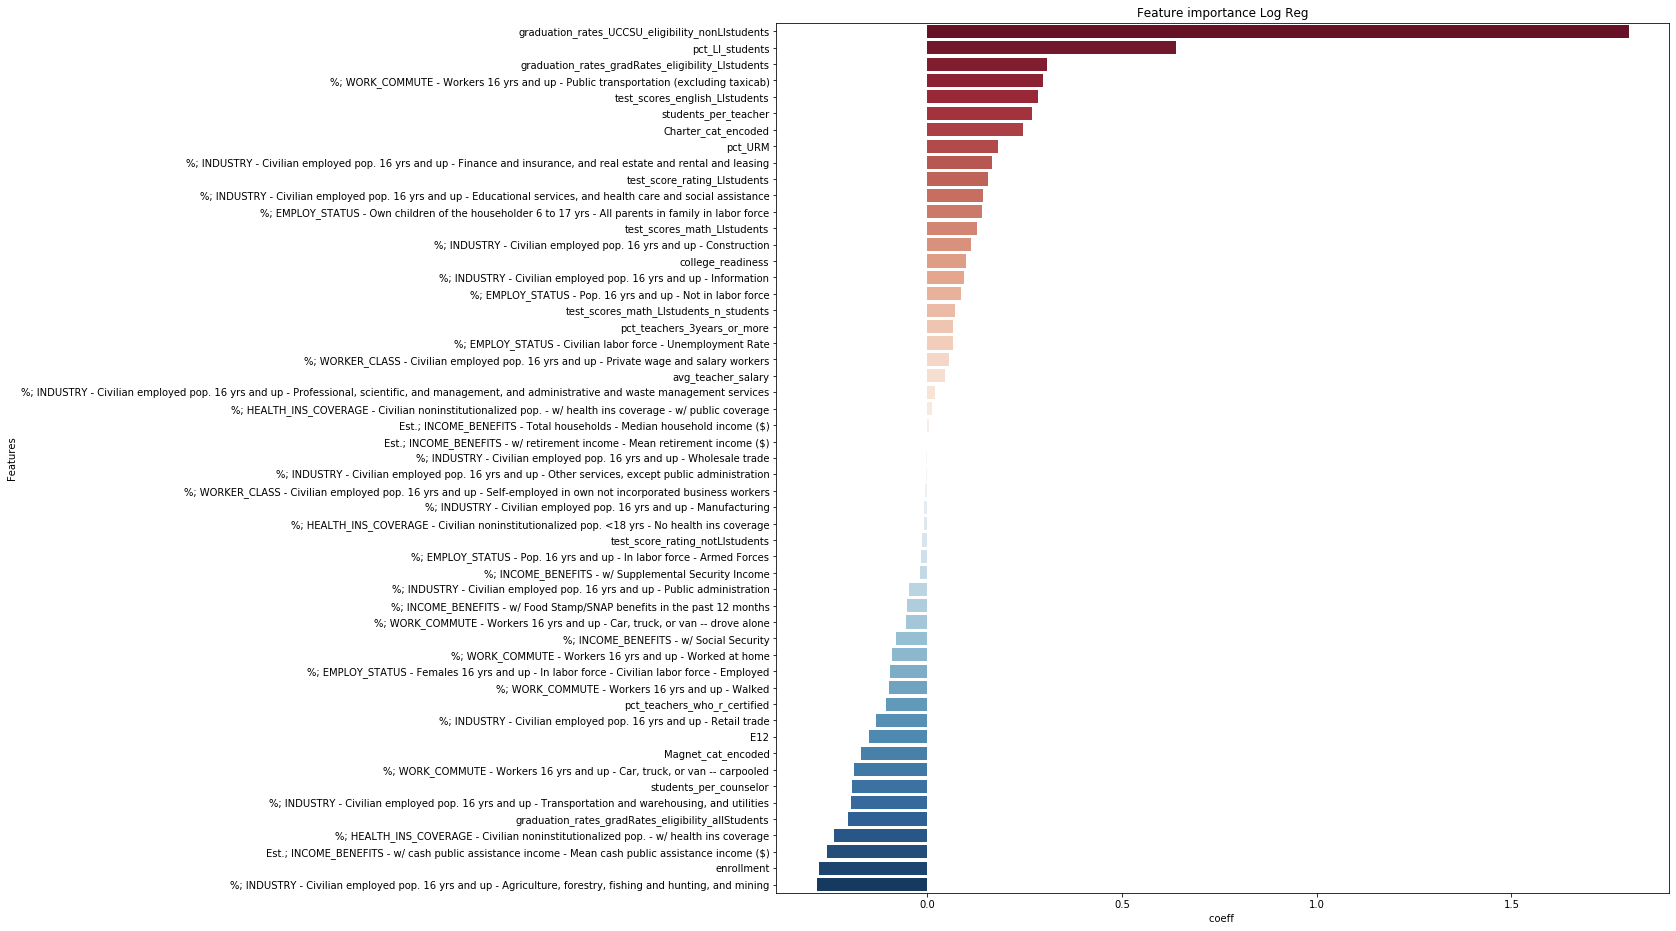

<IPython.core.display.Javascript object>

In [336]:
# calculate feature importance (coeff of logreg)
feature_importance = pd.DataFrame()
feature_importance['name'] = all_features_filt_wcensuscheck_notarget
feature_importance['coeff'] = log_reg_best.coef_[0]
print(feature_importance.sort_values(by=['coeff']))

# plot feature importance (horizontal)

f, ax1 = plt.subplots(figsize=(16,16))
sns.barplot(x='coeff', y='name', data=feature_importance.sort_values(by='coeff', ascending=False), palette='RdBu', ax=ax1)
ax1.set_xlabel('coeff ')
ax1.set_ylabel('Features')
ax1.set_title('Feature importance Log Reg')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

In [363]:
feature_importance.sort_values(by=['coeff'])

,name,coeff
15,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.283488
34,enrollment,-0.279608
6,Est.; INCOME_BENEFITS - w/ cash public assista...,-0.257663
7,%; HEALTH_INS_COVERAGE - Civilian noninstituti...,-0.239583
50,graduation_rates_gradRates_eligibility_allStud...,-0.205184
25,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.197112
41,students_per_counselor,-0.193346
11,"%; WORK_COMMUTE - Workers 16 yrs and up - Car,...",-0.189346
37,Magnet_cat_encoded,-0.170350
0,E12,-0.150403


<IPython.core.display.Javascript object>

In [340]:
[print(i) for i in feature_importance.sort_values(by=['coeff'])['name']]

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
enrollment
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage
graduation_rates_gradRates_eligibility_allStudents
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities
students_per_counselor
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled
Magnet_cat_encoded
E12
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
pct_teachers_who_r_certified
%; WORK_COMMUTE - Workers 16 yrs and up - Walked
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home
%; INCOME_BENEFITS - w/ Social Security
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
%; INCOME_BENEFITS 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

In [346]:
(feature_importance['coeff'] < 2).sum()

53

<IPython.core.display.Javascript object>

## Obtaining p-values of coefficients with custom function

From [StackOverflow post](https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance)

Caveats for this function:
- it is specifically for values with large C, but RandomizedSearchCV returned a small CV
- it's unclear how this handles regularization

In [364]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """

    import numpy as np
    from scipy.stats import norm
    from sklearn.linear_model import LogisticRegression

    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis=1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i, 1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t = coefs / se
    p = (1 - norm.cdf(abs(t))) * 2
    return p

<IPython.core.display.Javascript object>

In [377]:
log_reg_best4pvals = LogisticRegression(**log_reg_random_search.best_params_, class_weight=None)
log_reg_best4pvals.fit(X_train_LR, y_train)

LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [378]:
feature_importance_wpvalues = feature_importance.copy()
feature_importance_wpvalues['p_values'] = logit_pvalue(log_reg_best4pvals, X_test_LR)[1::]  # start at 1 to remove intercept

<IPython.core.display.Javascript object>

In [379]:
feature_importance_wpvalues.sort_values(by='p_values')

,name,coeff,p_values
52,graduation_rates_UCCSU_eligibility_nonLIstudents,1.801225,0.036612
6,Est.; INCOME_BENEFITS - w/ cash public assista...,-0.257663,0.619347
38,Charter_cat_encoded,0.244833,0.670244
36,pct_LI_students,0.637487,0.749936
40,students_per_teacher,0.269505,0.752857
41,students_per_counselor,-0.193346,0.857920
25,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.197112,0.861122
18,%; INDUSTRY - Civilian employed pop. 16 yrs an...,0.165155,0.866038
51,graduation_rates_gradRates_eligibility_LIstudents,0.307253,0.875933
47,test_scores_english_LIstudents,0.285322,0.880325


<IPython.core.display.Javascript object>

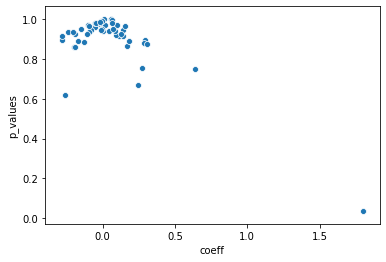

<IPython.core.display.Javascript object>

In [383]:
f, ax1 = plt.subplots()
sns.scatterplot(data=feature_importance_wpvalues, x='coeff', y='p_values');

In [385]:
feature_importance_wpvalues[feature_importance_wpvalues['p_values']<0.9].sort_values(by='coeff')

,name,coeff,p_values
15,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.283488,0.895542
6,Est.; INCOME_BENEFITS - w/ cash public assista...,-0.257663,0.619347
25,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.197112,0.861122
41,students_per_counselor,-0.193346,0.857920
37,Magnet_cat_encoded,-0.170350,0.889380
24,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.131977,0.882960
18,%; INDUSTRY - Civilian employed pop. 16 yrs an...,0.165155,0.866038
35,pct_URM,0.181706,0.890816
38,Charter_cat_encoded,0.244833,0.670244
40,students_per_teacher,0.269505,0.752857


<IPython.core.display.Javascript object>

# RF classification, target: exceptional schools

Standardizing features is not necessary for random forest.

## Run 4-fold cross-validation to get optimal parameters

In [347]:
# Random forest classification parameters to test
random_grid_rf = {
    'n_estimators': [50, 100, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 7],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4],
    'class_weight':['balanced']}

<IPython.core.display.Javascript object>

In [348]:
# Instantiate model
rf = RandomForestClassifier()

# Randomized search using 4-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid_rf,  # from above
    n_iter=5,  # no. of parameter settings sampled
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="f1",  
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_random_search = rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.4s finished


<IPython.core.display.Javascript object>

In [349]:
print('Random forest best parameters from search: ', rf_random_search.best_params_)

Random forest best parameters from search:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 4, 'criterion': 'entropy', 'class_weight': 'balanced'}


<IPython.core.display.Javascript object>

In [350]:
rf_random_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

**Fit model using hyperparameters.**

In [351]:
rf_best = RandomForestClassifier(**rf_random_search.best_params_)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

## Evalute optimized parameters on test (hold out) set

In [352]:
y_pred_RF = rf_best.predict(X_test)
df_eval_RF = pd.DataFrame({"test": y_test, "pred": y_pred_RF})

<IPython.core.display.Javascript object>

Recall: 0.4737
Accuracy: 0.1411
Precision: 0.6923
[[140   4]
 [ 10   9]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       144
           1       0.69      0.47      0.56        19

    accuracy                           0.91       163
   macro avg       0.81      0.72      0.76       163
weighted avg       0.91      0.91      0.91       163



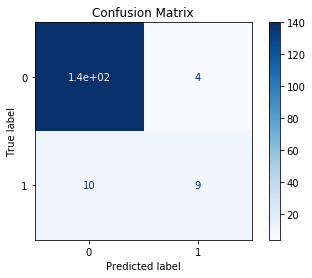

<IPython.core.display.Javascript object>

In [353]:
# Compute and print the confusion matrix and classification report
print('Recall: %.4f' %metrics.recall_score(df_eval_RF['test'], df_eval_RF['pred']))
print('Accuracy: %.4f' %log_reg_best.score(X_test, y_test))
print('Precision: %.4f' %metrics.precision_score(df_eval_RF['test'], df_eval_RF['pred']))
print(confusion_matrix(df_eval_RF['test'], df_eval_RF['pred']))
print(classification_report(df_eval_RF['test'], df_eval_RF['pred']))

f, ax1 = plt.subplots()
plot_confusion_matrix(rf_best, X_test, y_test, labels=None, 
                             sample_weight=None, normalize=None, display_labels=None, 
                             include_values=True, xticks_rotation='horizontal', 
                             values_format='d', cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix');

In [326]:
# Roc curve

<IPython.core.display.Javascript object>

## Most important features from random forest

In [354]:
features = all_features_filt_wcensuscheck_notarget

<IPython.core.display.Javascript object>

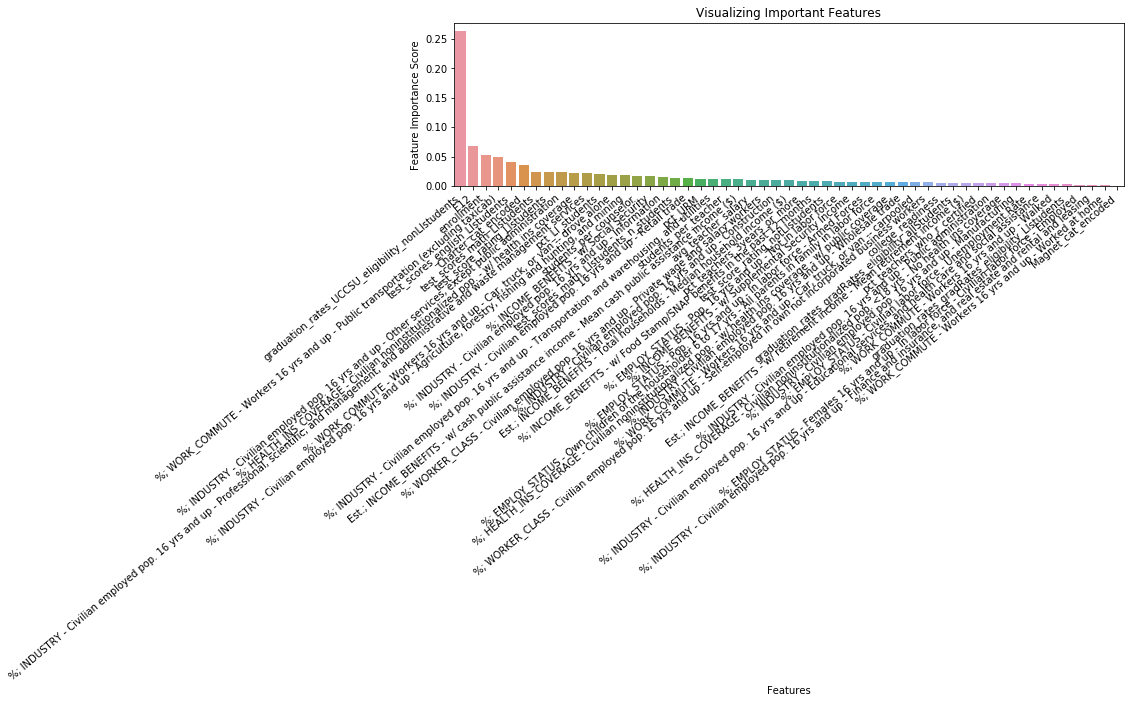

<IPython.core.display.Javascript object>

In [355]:
feature_imp = pd.Series(rf_best.feature_importances_,index=features).sort_values(ascending=False)

# Creating a bar plot
f, ax1 = plt.subplots(figsize=(12,3))
sns.barplot(y=feature_imp, x=feature_imp.index, ax=ax1)

# Add labels to your graph
ax1.set_xlabel('Features')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right')

ax1.set_ylabel('Feature Importance Score')
ax1.set_title('Visualizing Important Features');

In [356]:
pd.DataFrame({'rank':range(1, len(feature_imp)+1), 'feature':feature_imp.index, 'feature_imp_score':feature_imp.values})

,rank,feature,feature_imp_score
0,1,graduation_rates_UCCSU_eligibility_nonLIstudents,0.263924
1,2,E12,0.067980
2,3,enrollment,0.053248
3,4,%; WORK_COMMUTE - Workers 16 yrs and up - Publ...,0.049192
4,5,test_scores_english_LIstudents,0.040492
5,6,Charter_cat_encoded,0.036659
6,7,test_scores_math_LIstudents,0.024668
7,8,test_score_rating_LIstudents,0.023444
8,9,%; INDUSTRY - Civilian employed pop. 16 yrs an...,0.023250
9,10,%; HEALTH_INS_COVERAGE - Civilian noninstituti...,0.023175


<IPython.core.display.Javascript object>

In [357]:
feature_imp.sum()

1.0

<IPython.core.display.Javascript object>

## Features using SHAP values

In [358]:
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<IPython.core.display.Javascript object>

**That output includes features on predicting both classes, but we'll focus on positive class with shap_values[1].**

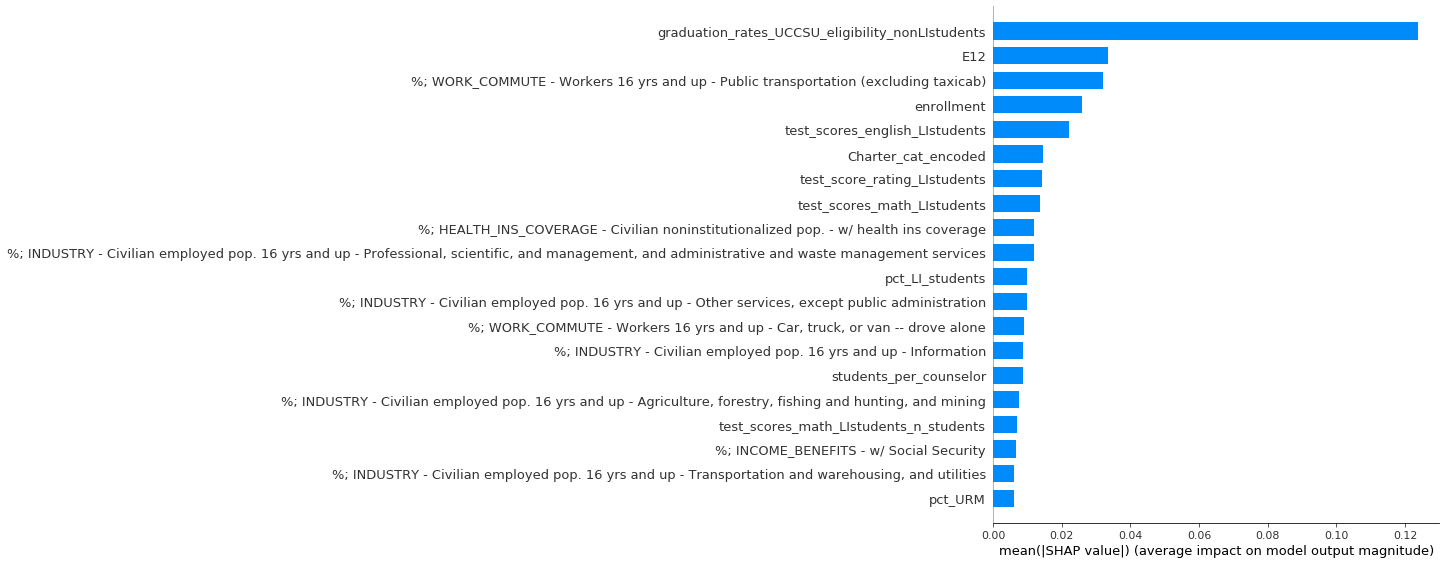

<IPython.core.display.Javascript object>

In [359]:
shap.summary_plot(shap_values[1], X_train, plot_type="bar")

In [360]:
def ABS_SHAP(df_shap, df, top_n):
    # import matplotlib as plt
    """
    Shows directionality (taken from blog post)
    """

    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop("index", axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(
        0
    )
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ["Variable", "Corr"]
    corr_df["Sign"] = np.where(corr_df["Corr"] > 0, "red", "blue")

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ["Variable", "SHAP_abs"]
    k2 = k.merge(corr_df, left_on="Variable", right_on="Variable", how="inner")
    k2 = k2.sort_values(by="SHAP_abs", ascending=True).tail(
        top_n
    )  # Added top_n to limit features
    colorlist = k2["Sign"]
    ax = k2.plot.barh(
        x="Variable", y="SHAP_abs", color=colorlist, figsize=(20, 16), legend=False,
    )
    ax.set_yticklabels(labels=k2["Variable"], fontsize=24)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)", fontsize=24)
    ax.set_ylabel("")

    # return k2

    # ABS_SHAP(shap_values,X_train,top_n)
    # view rawABS_SHAP hosted with ❤ by GitHub

<IPython.core.display.Javascript object>

invalid value encountered in true_divide
invalid value encountered in true_divide


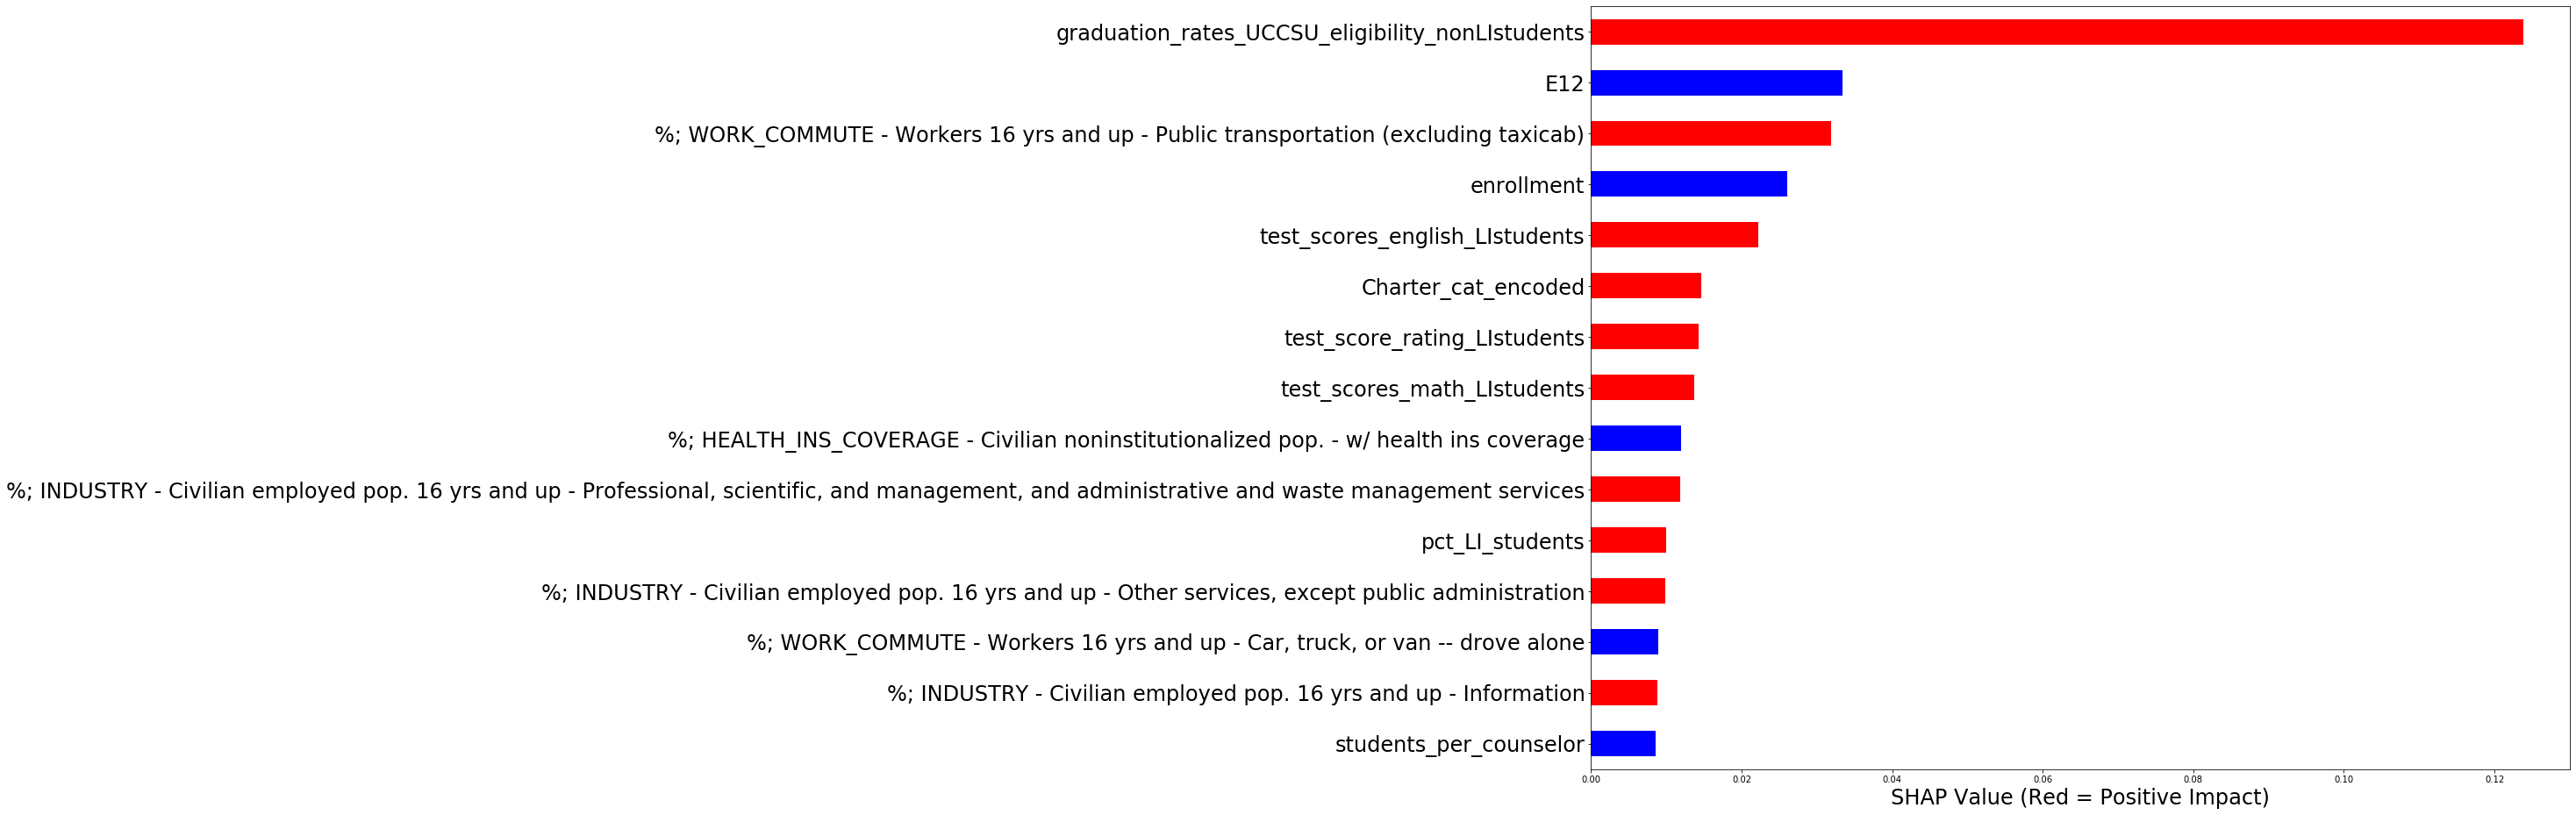

<IPython.core.display.Javascript object>

In [361]:
ABS_SHAP(shap_values[1], X_train, 15)

# Statistical analysis

In [388]:
def scatter_plot_open_circles(df, feature_x, feature_y, ax):
    x = df[feature_x]
    y = df[feature_y]
    ax.scatter(x, y, facecolors="none", edgecolors=B_dkgray)
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

<IPython.core.display.Javascript object>

In [389]:
def hist_plot(df, feature, ax):
    df[feature].hist(ax=ax, bins=30, color=B_slate)
    ax.set_title(feature)

<IPython.core.display.Javascript object>

In [386]:
def run_mannwhitneyu(df, metric_col, bin_col):
    class0 = sorted(df[bin_col].unique())[0]
    class1 = sorted(df[bin_col].unique())[1]
    x = df.loc[df[bin_col] == class0, metric_col]
    y = df.loc[df[bin_col] == class1, metric_col]
    mwu_statistic, mwu_pval = mannwhitneyu(x, y, use_continuity=True, alternative=None)
    return mwu_pval

<IPython.core.display.Javascript object>

mean:  45.75675675675676
mean +/- 1SD:  28.30494864995583 63.20856486355768


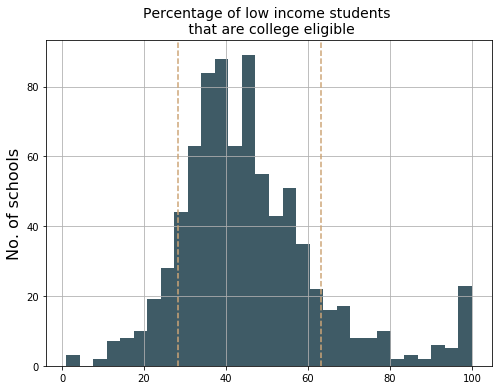

<IPython.core.display.Javascript object>

In [392]:
f, ax1 = plt.subplots(figsize=(8,6))
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LIstudents", ax1)
ax1.set_ylabel("No. of schools", fontsize=16)
ax1.set_title("Percentage of low income students \n that are college eligible", fontsize=14);

target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

# or top and bottom quantile

ax1.axvline(target_mean-target_sd, c=B_beige, linestyle="dashed")
ax1.axvline(target_mean+target_sd, c=B_beige, linestyle="dashed")

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd);


In [401]:
feat_for_stats_test = all_features_filt_wcensuscheck_notarget
feat_for_stats_test[0:5]

['E12',
 '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
 '%; INCOME_BENEFITS - w/ Social Security',
 '%; INCOME_BENEFITS - w/ Supplemental Security Income',
 'Est.; INCOME_BENEFITS - Total households - Median household income ($)']

<IPython.core.display.Javascript object>

## Evaluate exceptional vs. non-exceptional schoools

In [398]:
df_state_info_gs_census['splice_high'].head()

0    1
1    0
4    0
5    0
6    0
Name: splice_high, dtype: int64

<IPython.core.display.Javascript object>

In [402]:
df_state_info_gs_census_forMW_splice_high = df_state_info_gs_census.loc[:, feat_for_stats_test + ["splice_high"]].copy()

<IPython.core.display.Javascript object>

In [404]:
df_state_info_gs_census_forMW_splice_high.head()

,E12,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,%; INCOME_BENEFITS - w/ Social Security,%; INCOME_BENEFITS - w/ Supplemental Security Income,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage,...,avg_teacher_salary,test_score_rating_LIstudents,test_score_rating_notLIstudents,test_scores_english_LIstudents,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,graduation_rates_gradRates_eligibility_allStudents,graduation_rates_gradRates_eligibility_LIstudents,graduation_rates_UCCSU_eligibility_nonLIstudents,splice_high
0,88,9.2,24.0,16.0,32993.0,29027.0,5055.0,82.2,41.3,4.7,...,56500.0,4.0,4.0,47.0,18.0,77.0,82.0,83.0,100.000000,1
1,381,6.1,21.9,5.0,72884.0,32115.0,4632.0,89.9,25.8,6.0,...,67831.0,8.0,10.0,64.0,49.0,104.0,95.0,94.0,69.512195,0
4,285,4.0,19.7,3.3,80970.0,36487.0,4229.0,94.3,19.0,2.4,...,99680.0,8.0,10.0,66.0,45.0,55.0,93.0,92.0,66.686747,0
5,798,3.6,9.5,2.8,26478.0,40397.0,8172.0,92.8,11.1,1.5,...,68887.0,5.0,10.0,45.0,27.0,172.0,89.0,89.0,72.222222,0
6,702,5.1,29.2,4.0,76269.0,32035.0,6020.0,91.9,26.2,2.7,...,80378.0,7.0,9.0,56.0,51.0,144.0,97.0,96.0,63.500000,0


<IPython.core.display.Javascript object>

In [455]:
df_sig_features = pd.DataFrame()
df_sig_features["feature"] = None
df_sig_features["raw_pval"] = None

for i, feature in enumerate(feat_for_stats_test):
    mwu_pval_feature = run_mannwhitneyu(
        df_state_info_gs_census_forMW_splice_high, feature, "splice_high"
    )

    df_sig_features.loc[i, "feature"] = feature
    df_sig_features.loc[i, "raw_pval"] = mwu_pval_feature

df_sig_features = df_sig_features.sort_values(
    by="raw_pval", ascending=True
).reset_index()

bonferroni_reject, bonferroni_p_val_corrected = multitest.multipletests(
    df_sig_features["raw_pval"], alpha=0.05, method="bonferroni"
)[0:2]

df_sig_features["corr_p_val_rej"] = bonferroni_reject
df_sig_features["corr_p_val"] = bonferroni_p_val_corrected

<IPython.core.display.Javascript object>

In [456]:
df_sig_features

,index,feature,raw_pval,corr_p_val_rej,corr_p_val
0,52,graduation_rates_UCCSU_eligibility_nonLIstudents,2.98419e-47,True,1.58162e-45
1,38,Charter_cat_encoded,4.61339e-43,True,2.4451e-41
2,12,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),2.56104e-14,True,1.35735e-12
3,47,test_scores_english_LIstudents,2.63159e-12,True,1.39474e-10
4,34,enrollment,4.74387e-10,True,2.51425e-08
5,0,E12,1.05372e-09,True,5.58473e-08
6,45,test_score_rating_LIstudents,1.75257e-09,True,9.28861e-08
7,41,students_per_counselor,3.6904e-09,True,1.95591e-07
8,49,test_scores_math_LIstudents_n_students,4.70186e-09,True,2.49198e-07
9,19,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information,1.11113e-08,True,5.88899e-07


<IPython.core.display.Javascript object>

In [457]:
[print(i, v) for i, v in enumerate(df_sig_features['feature']) if i < 21]

0 graduation_rates_UCCSU_eligibility_nonLIstudents
1 Charter_cat_encoded
2 %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
3 test_scores_english_LIstudents
4 enrollment
5 E12
6 test_score_rating_LIstudents
7 students_per_counselor
8 test_scores_math_LIstudents_n_students
9 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
10 %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
11 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
12 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
13 %; INCOME_BENEFITS - w/ Social Security
14 test_scores_math_LIstudents
15 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
16 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
17 pct_LI_students
18 avg_teacher_salary
19 %; WORKER_CLASS - Civil

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

### Inspect Mann-Whitney p-values and logistic regression coefficients

In [458]:
# From above
df_sig_features.head()

,index,feature,raw_pval,corr_p_val_rej,corr_p_val
0,52,graduation_rates_UCCSU_eligibility_nonLIstudents,2.98419e-47,True,1.58162e-45
1,38,Charter_cat_encoded,4.61339e-43,True,2.4451e-41
2,12,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),2.56104e-14,True,1.35735e-12
3,47,test_scores_english_LIstudents,2.63159e-12,True,1.39474e-10
4,34,enrollment,4.74387e-10,True,2.51425e-08


<IPython.core.display.Javascript object>

In [459]:
# From logistic regression
feature_importance.head()

,name,coeff
0,E12,-0.150403
1,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,-0.052739
2,%; INCOME_BENEFITS - w/ Social Security,-0.081735
3,%; INCOME_BENEFITS - w/ Supplemental Security Income,-0.018268
4,Est.; INCOME_BENEFITS - Total households - Median household income ($),0.004627


<IPython.core.display.Javascript object>

### Join tables and sort

- Filter by p-value and absoltue value of coefficient

In [460]:
df_sig_features_LRcoeff = pd.merge(df_sig_features, feature_importance, left_on='feature', right_on='name').loc[:, ['feature', 'corr_p_val', 'coeff']]
df_sig_features_LRcoeff.head()

,feature,corr_p_val,coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,1.58162e-45,1.801225
1,Charter_cat_encoded,2.4451e-41,0.244833
2,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),1.35735e-12,0.296023
3,test_scores_english_LIstudents,1.39474e-10,0.285322
4,enrollment,2.51425e-08,-0.279608


<IPython.core.display.Javascript object>

In [461]:
df_sig_features_LRcoeff['abs_coeff'] = np.abs(df_sig_features_LRcoeff['coeff'].copy())

<IPython.core.display.Javascript object>

In [462]:
pd.set_option('max_colwidth', 100)

<IPython.core.display.Javascript object>

In [467]:
df_sig_features_LRcoeff.sort_values(by='coeff')

,feature,corr_p_val,coeff,abs_coeff
12,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...",9.12814e-05,-0.283488,0.283488
4,enrollment,2.51425e-08,-0.279608,0.279608
32,Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),0.960022,-0.257663,0.257663
30,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,0.470717,-0.239583,0.239583
42,graduation_rates_gradRates_eligibility_allStudents,1,-0.205184,0.205184
37,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities",1,-0.197112,0.197112
7,students_per_counselor,1.95591e-07,-0.193346,0.193346
25,"%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled",0.096861,-0.189346,0.189346
50,Magnet_cat_encoded,1,-0.170350,0.170350
5,E12,5.58473e-08,-0.150403,0.150403


<IPython.core.display.Javascript object>

In [464]:
bool_coeff_mwpval = (df_sig_features_LRcoeff['corr_p_val'] < 0.05) & (df_sig_features_LRcoeff['abs_coeff'] > 0.1)
df_sig_features_LRcoeff[bool_coeff_mwpval]

,feature,corr_p_val,coeff,abs_coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,1.58162e-45,1.801225,1.801225
1,Charter_cat_encoded,2.4451e-41,0.244833,0.244833
2,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),1.35735e-12,0.296023,0.296023
3,test_scores_english_LIstudents,1.39474e-10,0.285322,0.285322
4,enrollment,2.51425e-08,-0.279608,0.279608
5,E12,5.58473e-08,-0.150403,0.150403
6,test_score_rating_LIstudents,9.28861e-08,0.154505,0.154505
7,students_per_counselor,1.95591e-07,-0.193346,0.193346
12,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...",9.12814e-05,-0.283488,0.283488
14,test_scores_math_LIstudents,0.000348327,0.128150,0.128150


<IPython.core.display.Javascript object>

In [465]:
len(df_sig_features_LRcoeff[bool_coeff_mwpval])

13

<IPython.core.display.Javascript object>

In [466]:
[print(i) for i in df_sig_features_LRcoeff.loc[bool_coeff_mwpval, 'feature']]

graduation_rates_UCCSU_eligibility_nonLIstudents
Charter_cat_encoded
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
test_scores_english_LIstudents
enrollment
E12
test_score_rating_LIstudents
students_per_counselor
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
test_scores_math_LIstudents
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
pct_LI_students
pct_teachers_who_r_certified


[None, None, None, None, None, None, None, None, None, None, None, None, None]

<IPython.core.display.Javascript object>

## Evaluate top and bottom performing schools

mean:  45.75675675675676
mean +/- 1SD:  28.30494864995583 63.20856486355768


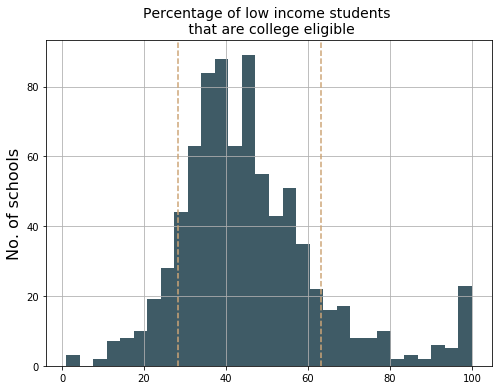

<IPython.core.display.Javascript object>

In [390]:
f, ax1 = plt.subplots(figsize=(8,6))
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LIstudents", ax1)
ax1.set_ylabel("No. of schools", fontsize=16)
ax1.set_title("Percentage of low income students \n that are college eligible", fontsize=14);

target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

# or top and bottom quantile

ax1.axvline(target_mean-target_sd, c=B_beige, linestyle="dashed")
ax1.axvline(target_mean+target_sd, c=B_beige, linestyle="dashed")

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd);


In [393]:
print(
    "No. of low performing schools: ",
    (
        df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
        < target_mean - target_sd
    ).sum(),
)

print(
    "No. of high performing schools: ",
    (
        df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
        > target_mean + target_sd
    ).sum(),
)

No. of low performing schools:  91
No. of high performing schools:  100


<IPython.core.display.Javascript object>

In [764]:
df_state_info_gs_census["LI_performance_status"] = "middle"

bool_low = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] < (
    target_mean - target_sd
)
df_state_info_gs_census.loc[bool_low, "LI_performance_status"] = "low"

bool_high = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] > (
    target_mean + target_sd
)
df_state_info_gs_census.loc[bool_high, "LI_performance_status"] = "high"

df_state_info_gs_census["LI_performance_status"].value_counts()

middle    904
high      137
low       111
Name: LI_performance_status, dtype: int64

<IPython.core.display.Javascript object>

In [771]:
feat_for_mw = all_features_filt_wcensuscheck[:-4]
feat_for_mw

['%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
 '%; INCOME_BENEFITS - w/ Social Security',
 '%; INCOME_BENEFITS - w/ Supplemental Security Income',
 'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
 'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)',
 '%; WORK_COMMUTE - Workers

<IPython.core.display.Javascript object>

In [774]:
status2keep = ["low", "high"]

df_state_info_gs_census_forMW = df_state_info_gs_census.loc[
    df_state_info_gs_census["LI_performance_status"].isin(status2keep),
    feat_for_mw + ["LI_performance_status"],
].copy()

<IPython.core.display.Javascript object>

In [775]:
df_state_info_gs_census_forMW.head()

,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,%; INCOME_BENEFITS - w/ Social Security,%; INCOME_BENEFITS - w/ Supplemental Security Income,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage,"%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone",...,students_per_counselor,pct_teachers_3years_or_more,pct_teachers_who_r_certified,avg_teacher_salary,test_score_rating_LIstudents,test_score_rating_notLIstudents,test_scores_english_LIstudents,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,LI_performance_status
0,9.2,24.0,16.0,32993.0,29027.0,5055.0,82.2,41.3,4.7,30.5,...,343.0,31.0,100.0,56500.0,4.0,4.0,47.0,18.0,77.0,high
2,28.4,20.0,13.4,31903.0,19269.0,5347.0,80.2,48.5,6.7,59.4,...,147.0,82.0,67.0,41722.0,22.0,22.0,22.0,NaN,NaN,high
3,28.4,20.0,13.4,31903.0,19269.0,5347.0,80.2,48.5,6.7,59.4,...,NaN,64.0,90.0,51656.0,7.0,7.0,63.0,NaN,NaN,high
13,9.9,29.0,8.1,76773.0,20501.0,4077.0,90.3,29.4,2.9,77.2,...,188.0,75.0,96.0,62587.0,9.0,10.0,75.0,44.0,102.0,high
19,4.5,25.8,5.5,86757.0,20687.0,4531.0,90.4,29.6,4.0,77.0,...,444.0,87.0,93.0,105027.0,3.0,6.0,42.0,14.0,180.0,low


<IPython.core.display.Javascript object>

In [811]:
df_sig_features = pd.DataFrame()
df_sig_features["feature"] = None
df_sig_features["raw_pval"] = None


for i, feature in enumerate(feat_for_mw):
    mwu_pval_feature = run_mannwhitneyu(
        df_state_info_gs_census_forMW, feature, "LI_performance_status"
    )
    if mwu_pval_feature < 0.05:
        df_sig_features.loc[i, "feature"] = feature
        df_sig_features.loc[i, "raw_pval"] = mwu_pval_feature

df_sig_features = df_sig_features.sort_values(
    by="raw_pval", ascending=True
).reset_index()

bonferroni_reject, bonferroni_p_val_corrected = multitest.multipletests(
    df_sig_features["raw_pval"], alpha=0.05, method="bonferroni"
)[0:2]

df_sig_features["corr_p_val_rej"] = bonferroni_reject
df_sig_features["corr_p_val"] = bonferroni_p_val_corrected

<IPython.core.display.Javascript object>

In [831]:
df_sig_features.loc[df_sig_features["corr_p_val_rej"], ["feature", "corr_p_val"]]

,feature,corr_p_val
0,%; WORK_COMMUTE - Workers 16 yrs and up - Publ...,5.07987e-19
1,%; INDUSTRY - Civilian employed pop. 16 yrs an...,7.23522e-17
2,%; INCOME_BENEFITS - w/ Social Security,5.22535e-14
3,%; WORKER_CLASS - Civilian employed pop. 16 yr...,1.01559e-13
4,test_scores_english_LIstudents,4.72221e-13
5,Charter_cat_encoded,2.54253e-12
6,%; INDUSTRY - Civilian employed pop. 16 yrs an...,1.23895e-11
7,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in...,1.76531e-11
8,%; INDUSTRY - Civilian employed pop. 16 yrs an...,4.63625e-11
9,%; INDUSTRY - Civilian employed pop. 16 yrs an...,2.34242e-09


<IPython.core.display.Javascript object>

In [834]:
[print(i, feature) for i, feature in enumerate(df_sig_features["feature"])]

0 %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
1 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
2 %; INCOME_BENEFITS - w/ Social Security
3 %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers
4 test_scores_english_LIstudents
5 Charter_cat_encoded
6 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
7 %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
8 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
9 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
10 test_scores_math_LIstudents
11 test_score_rating_LIstudents
12 %; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
13 %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
14 %; HEALTH_INS_COVERAGE - 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

## First pass of boxplots - by order of significance

%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
%; INCOME_BENEFITS - w/ Social Security


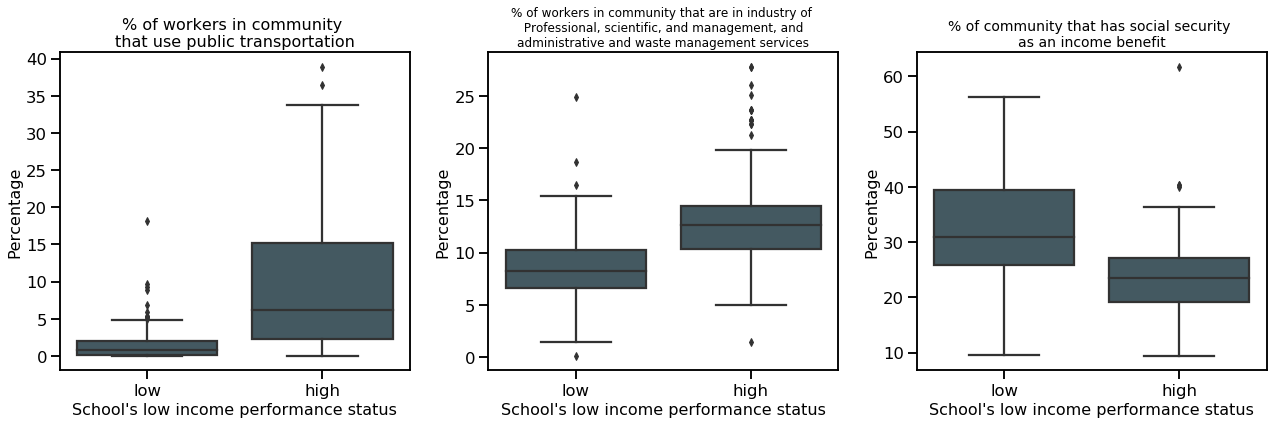

<IPython.core.display.Javascript object>

In [833]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [0,1,2]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in community \nthat use public transportation", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in community that are in industry of \n Professional, scientific, and management, and \nadministrative and waste management services", fontsize=12)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of community that has social security \nas an income benefit", fontsize=14)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)


plt.tight_layout();



%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force


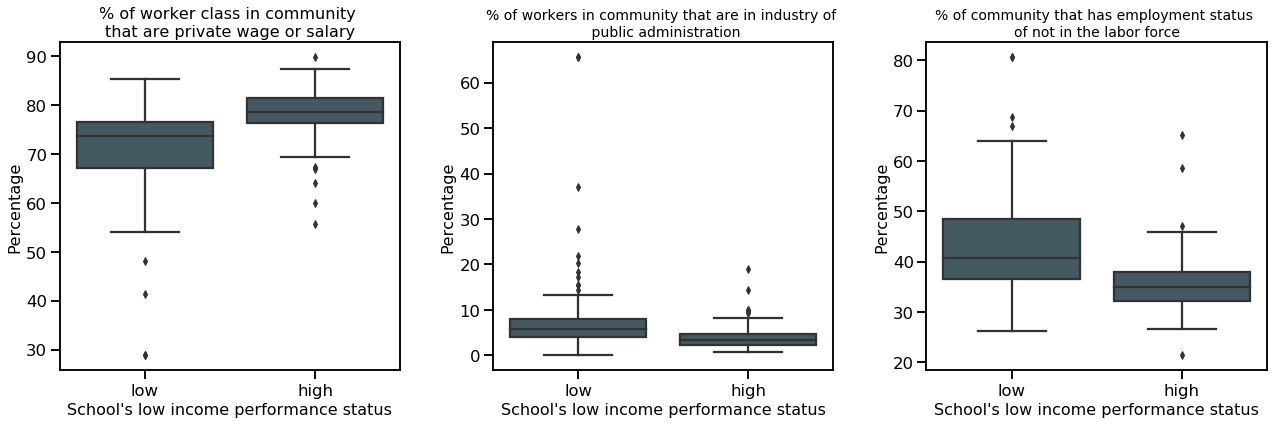

<IPython.core.display.Javascript object>

In [838]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [3, 6, 7]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title(
    "% of worker class in community \nthat are private wage or salary", fontsize=16
)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of workers in community that are in industry of \n public administration",
    fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title(
    "% of community that has employment status \nof not in the labor force", fontsize=14
)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed


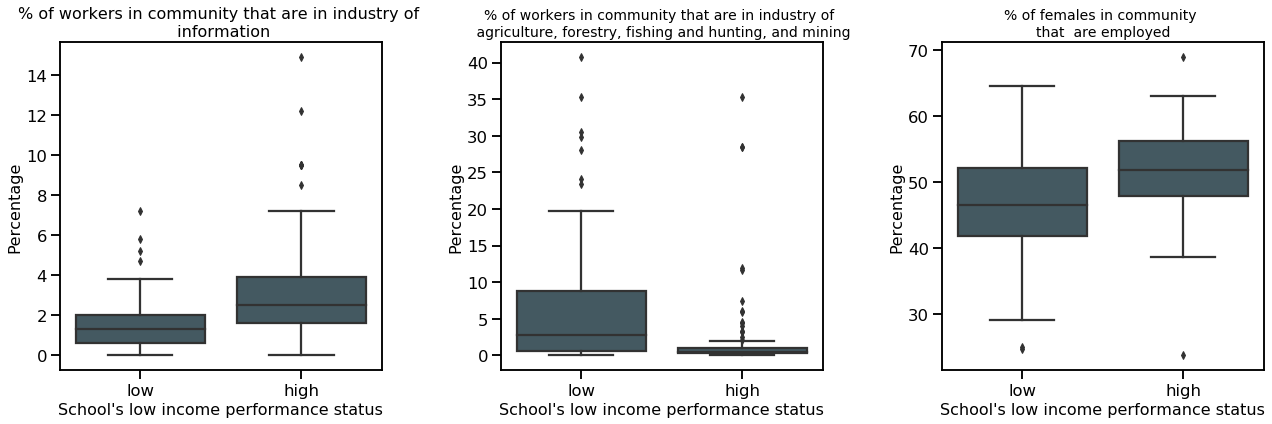

<IPython.core.display.Javascript object>

In [840]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [8, 9, 12]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title(
    "% of workers in community that are in industry of \n information", fontsize=16
)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of workers in community that are in industry of \n agriculture, forestry, fishing and hunting, and mining",
    fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of females in community \nthat  are employed", fontsize=14)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing


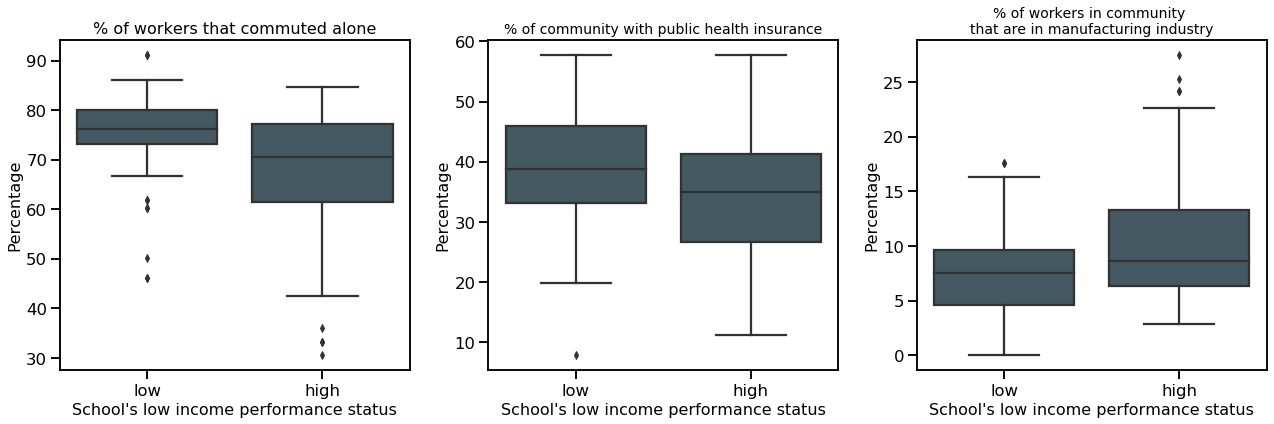

<IPython.core.display.Javascript object>

In [842]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [13, 14, 15]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers that commuted alone", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of community with public health insurance", fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title(
    "% of workers in community \nthat are in manufacturing industry", fontsize=14
)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

## Second pass of boxplots - by category

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing


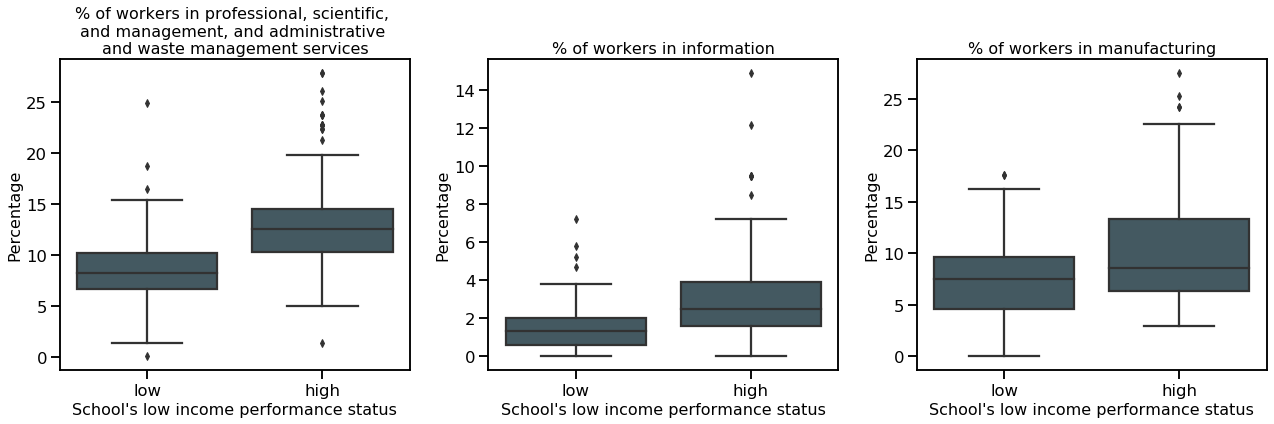

<IPython.core.display.Javascript object>

In [851]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [1,8,15]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in professional, scientific, \nand management, and administrative \nand waste management services", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in information", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of workers in manufacturing", fontsize=16)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining


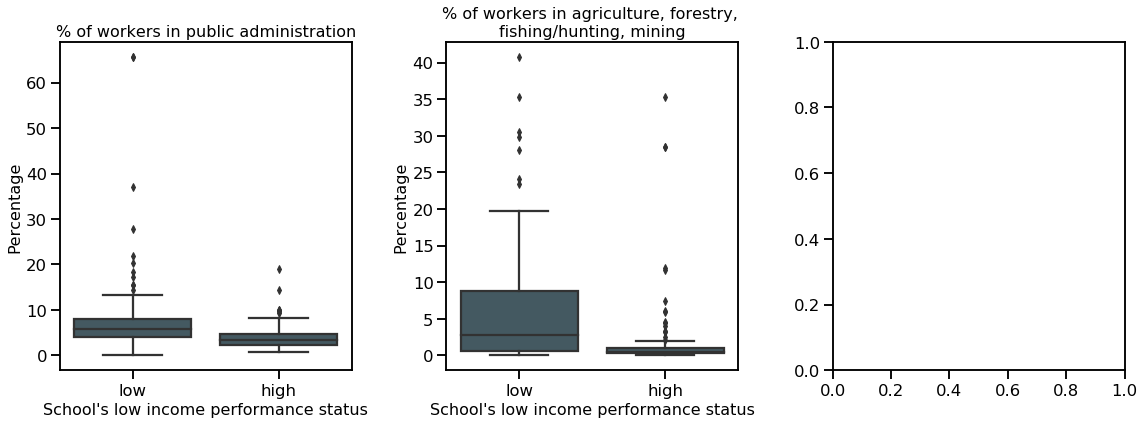

<IPython.core.display.Javascript object>

In [858]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [6,9]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in public administration", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in agriculture, forestry, \nfishing/hunting, mining", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();



%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed


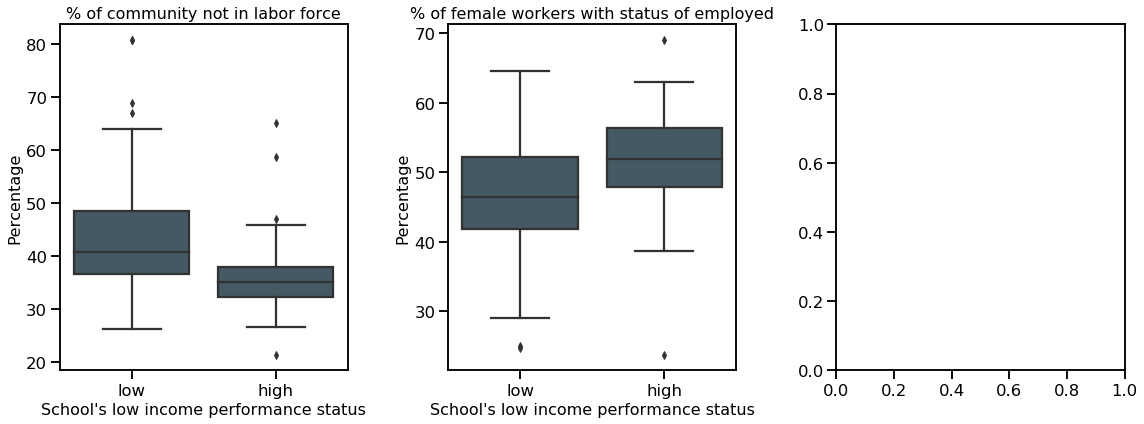

<IPython.core.display.Javascript object>

In [856]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [7,12]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of community not in labor force", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of female workers with status of employed", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone


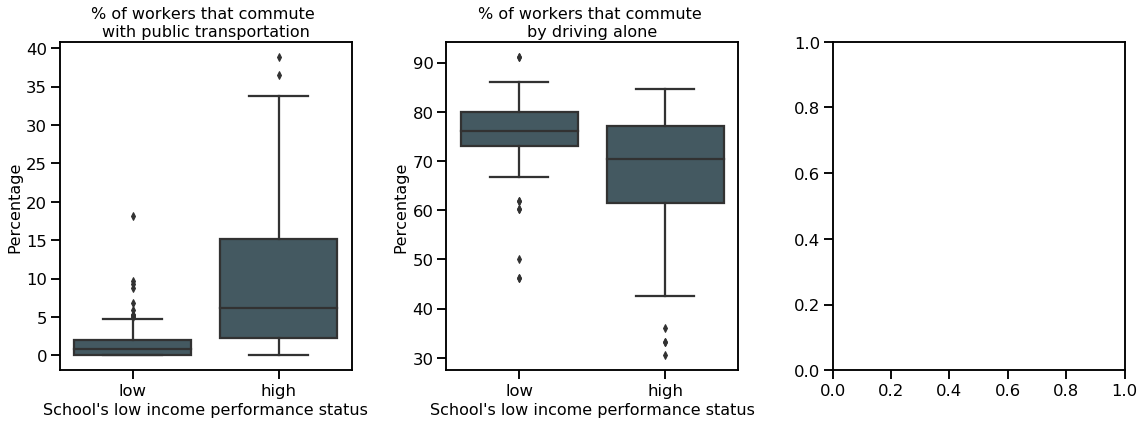

<IPython.core.display.Javascript object>

In [855]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [0,13]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers that commute \nwith public transportation", fontsize=16)
ax1.set_xlabel("School's low incomae performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers that commute \nby driving alone", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; INCOME_BENEFITS - w/ Social Security
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage


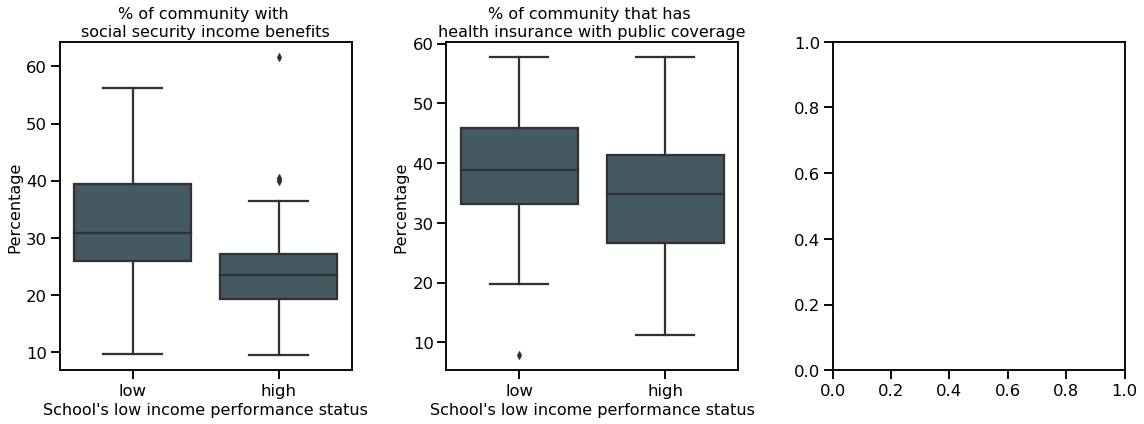

<IPython.core.display.Javascript object>

In [861]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [2,14]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of community with \nsocial security income benefits", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of community that has \nhealth insurance with public coverage", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();



## Different schools of same zip code

# ---